In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, Set, Tuple, List, Iterable, Optional, Hashable

In [2]:
LAYER1_GEXF = "/Users/HP/Desktop/layer1.gexf"
LAYER2_GEXF = "/Users/HP/Desktop/layer2.gexf"

RESULTS = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null.npy'


In [3]:
print(f"Loading Layer 1 from: {LAYER1_GEXF}")
layer1 = nx.read_gexf(LAYER1_GEXF)
print(f"Loaded Layer 1: |V|={layer1.number_of_nodes()}, |E|={layer1.number_of_edges()}")

Loading Layer 1 from: /Users/HP/Desktop/layer1.gexf
Loaded Layer 1: |V|=2599, |E|=55052


In [4]:
print(f"Loading Layer 3 from: {LAYER2_GEXF}")
layer3 = nx.read_gexf(LAYER2_GEXF)
print(f"Loaded Layer 3: |V|={layer3.number_of_nodes()}, |E|={layer3.number_of_edges()}")

Loading Layer 3 from: /Users/HP/Desktop/layer2.gexf
Loaded Layer 3: |V|=1084, |E|=54210


In [5]:
edge_overlap_ratios = np.load(RESULTS)
print(f"Loaded edge overlap ratios from {RESULTS}, shape: {edge_overlap_ratios.shape}")

Loaded edge overlap ratios from /Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edge_overlap_L1_Null.npy, shape: (1500,)


In [6]:
def _edge_set_undirected(G: nx.Graph) -> Set[Tuple[Hashable, Hashable]]:
    out = set()
    for u, v in G.edges():
        if u == v:
            continue
        try:
            a, b = (u, v) if u < v else (v, u)
        except TypeError:
            a, b = (u, v) if str(u) < str(v) else (v, u)
        out.add((a, b))
    return out

In [7]:
E1 = _edge_set_undirected(layer1)
E2 = _edge_set_undirected(layer3)
expected_edge_overlap_ratio = len(E1 & E2) / min(len(E1), len(E2)) if min(len(E1), len(E2)) > 0 else 0.0

Expected edge overlap ratio: 0.0509131156613171
Mean edge overlap ratio: 0.02773687511529238
Standard deviation edge overlap ratio: 0.0005140732788091332


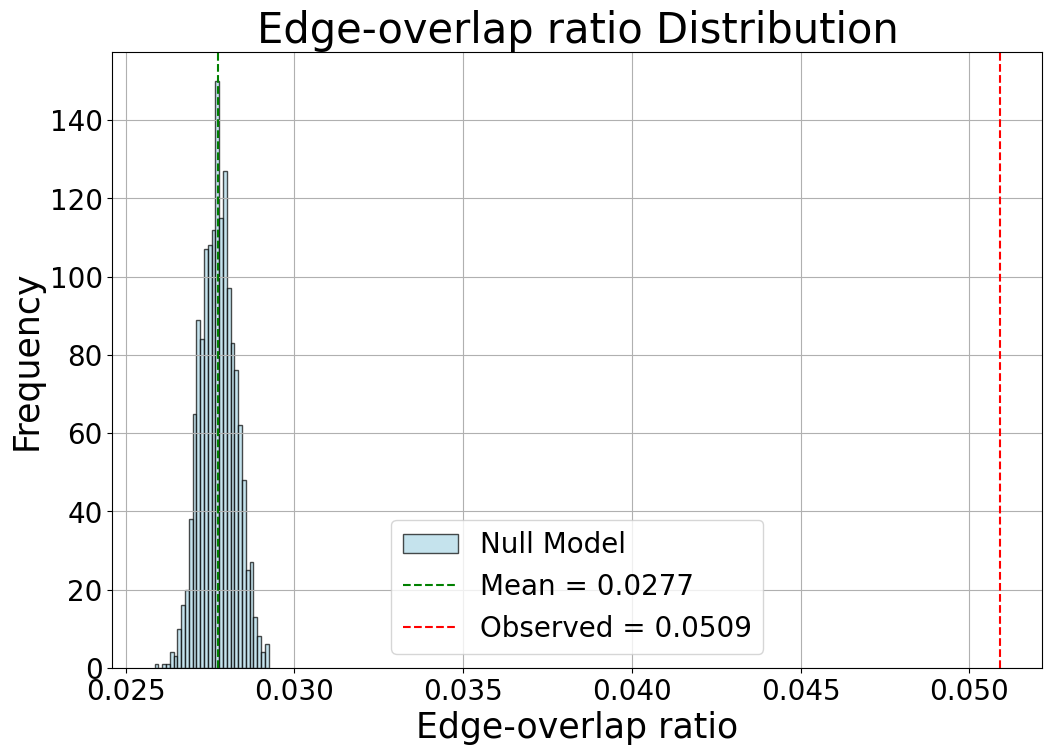

In [8]:
plt.figure(figsize=(12, 8))
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')

print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.4f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.4f}")
plt.legend(fontsize=20)
plt.show()